# Setup environment

In [1]:
library(tidyverse)
options(repr.plot.width=3, repr.plot.height=2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [5]:
getwd()
source("gplot_theme.R")

[1] "/home/clint/GitRepo/Statistics/BIOS706_FinalProj"

# Read Data

In [3]:
dat_camp <- read_csv("camp_teach.csv")

Parsed with column specification:
cols(
  .default = col_integer(),
  TX = col_character(),
  TG = col_character(),
  GENDER = col_character(),
  ETHNIC = col_character(),
  hemog = col_double(),
  PREFEV = col_double(),
  PREFVC = col_double(),
  POSFEV = col_double(),
  POSFVC = col_double(),
  visitc = col_character()
)
See spec(...) for full column specifications.


In [4]:
colnames(dat_camp)

[1] "TX"            "TG"            "id"            "age_rz"       
 [5] "GENDER"        "ETHNIC"        "hemog"         "PREFEV"       
 [9] "PREFVC"        "PREFF"         "PREPF"         "POSFEV"       
[13] "POSFVC"        "POSFF"         "POSPF"         "PREFEVPP"     
[17] "PREFVCPP"      "POSFEVPP"      "POSFVCPP"      "wbc"          
[21] "agehome"       "anypet"        "woodstove"     "dehumid"      
[25] "parent_smokes" "any_smokes"    "visitc"        "fdays"

# Preprocess

In [31]:
length(unique(dat_camp$id))

[1] 695

In [6]:
tmp <- dat_camp

# Treatment Group
tmp_map <-        c("bud", "ned", "plbo")
names(tmp_map) <- c("A",   "B",   "C")
tmp$TrtGrp <- tmp_map[tmp$TG]

# Exposed to Smoke
tmp1 <- ifelse(tmp$parent_smokes == 1, 1, 0)
tmp2 <- ifelse(tmp$any_smokes    == 1, 1, 0)
tmp$Expose_Smk <- ifelse((tmp1 + tmp2) > 0, "Exposed", "Not Exposed")

dat_camp_prep <- tmp

Get the baseline of study

In [33]:
tmp <- dat_camp_prep

# get the baseline
tmp <- tmp %>% filter(visitc == "000")
cat("Baseline (before filtered)", nrow(tmp), "\n")

# filter out missing value
tmp <- tmp %>% filter(
    !is.na(PREFEV), 
    !is.na(POSFEV),
    !is.na(PREFEVPP), 
    !is.na(POSFEVPP))

# assign and print nrow
dat_camp_base <- tmp
cat("Baseline (after filtered)", nrow(tmp), "\n")

Baseline (before filtered) 695 
Baseline (after filtered) 686 


In [34]:
table(dat_camp_base$Expose_Smk, useNA = "ifany")


    Exposed Not Exposed 
        203         483 

get the last observation point

In [45]:
tmp <- dat_camp_prep

# filter out missing value
tmp <- tmp %>% filter(
    !is.na(PREFEV), 
    !is.na(POSFEV),
    !is.na(PREFEVPP), 
    !is.na(POSFEVPP))

# get the last observation
tmp <- tmp %>% 
    group_by(id) %>%
    filter(visitc == max(visitc))

# assign and print nrow
dat_camp_last <- tmp
cat("Last obs.", nrow(tmp), "\n")

Last obs. 695 


In [36]:
table(dat_camp_last$Expose_Smk, useNA = "ifany")


    Exposed Not Exposed        <NA> 
          3          17         667 

combine baseline and last observation

In [80]:
tmp1  <- dat_camp_base %>% select(id, PREFEV, POSFEV, PREFEVPP, POSFEVPP) %>% mutate(CHGFEVPP = POSFEVPP - PREFEVPP)
tmp2  <- dat_camp_last %>% select(id, PREFEV, POSFEV, PREFEVPP, POSFEVPP) %>% mutate(CHGFEVPP = POSFEVPP - PREFEVPP)
tmp1$Time <- "Baseline"
tmp2$Time <- "LastObs"

tmp_id  <- intersect(dat_camp_base$id, dat_camp_last$id)
tmp_smk <- dat_camp_base %>% select(id, Expose_Smk)

tmp_dat <- bind_rows(tmp1, tmp2)
tmp_dat <- tmp_dat %>% filter(id %in% tmp_id)
tmp_dat <- left_join(tmp_dat, tmp_smk, by = "id")

dat_camp_final <- tmp_dat
cat("After combined", nrow(tmp), "\n")

After combined 1372 


# EDA

In [81]:
colnames(dat_camp_final)

[1] "id"         "PREFEV"     "POSFEV"     "PREFEVPP"   "POSFEVPP"  
[6] "CHGFEVPP"   "Time"       "Expose_Smk"

In [208]:
head(dat_camp_final, 3)

id,PREFEV,POSFEV,PREFEVPP,POSFEVPP,CHGFEVPP,Time,Expose_Smk
1,1.38,1.54,81,91,10,Baseline,Exposed
2,1.78,2.11,90,107,17,Baseline,Exposed
4,2.28,2.41,104,110,6,Baseline,Not Exposed


In [225]:
dat_camp_base <- dat_camp_final %>% filter(Time == "Baseline")
dat_camp_last <- dat_camp_final %>% filter(Time == "LastObs")

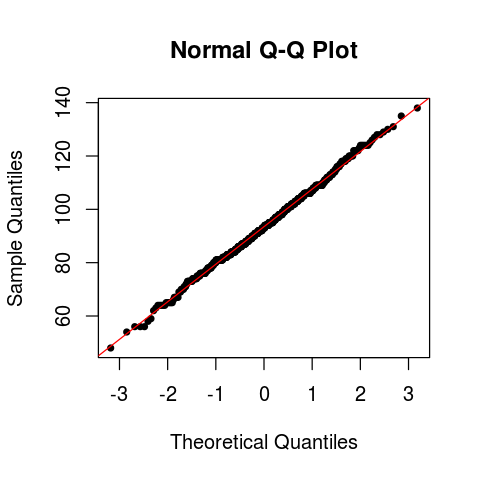

In [226]:
options(repr.plot.width=4, repr.plot.height=4)

x <- dat_camp_base$PREFEVPP
qqnorm(x, pch = 20)
qqline(x, col = "red")

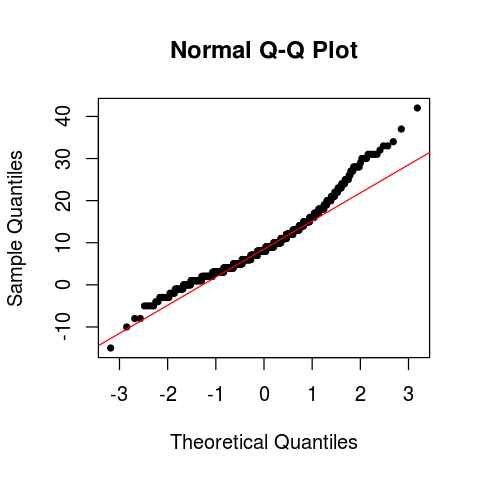

In [227]:
options(repr.plot.width=4, repr.plot.height=4)

x <- dat_camp_base$CHGFEVPP
qqnorm(x, pch = 20)
qqline(x, col = "red")

### Hypothesis One: Exposure to smoking is associated with decreased lung function at baseline

In [209]:
dat_camp_base <- dat_camp_final %>% filter(Time == "Baseline")
head(dat_camp_base, 3)

id,PREFEV,POSFEV,PREFEVPP,POSFEVPP,CHGFEVPP,Time,Expose_Smk
1,1.38,1.54,81,91,10,Baseline,Exposed
2,1.78,2.11,90,107,17,Baseline,Exposed
4,2.28,2.41,104,110,6,Baseline,Not Exposed


**as measured by the difference in pre-bronchodilator FEV1PP**

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”

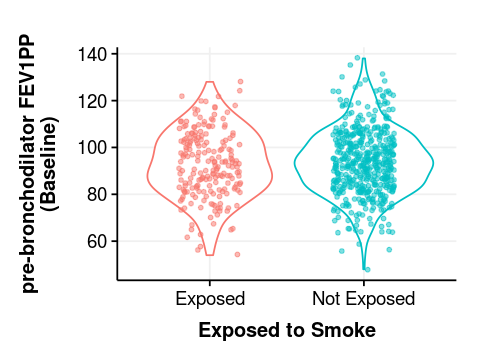

In [215]:
options(repr.plot.width=4, repr.plot.height=3)

gp <- dat_camp_base %>%
    ggplot(aes(x = Expose_Smk, y = PREFEVPP, color = Expose_Smk)) +
    geom_violin() +     
    geom_jitter(width = 0.2, size = 1, alpha = 0.5) + 
    xlab("Exposed to Smoke") + 
    ylab("pre-bronchodilator FEV1PP\n(Baseline)") + 
    theme_Publication() + 
    theme(legend.position="none") + 
    theme(axis.title = element_text(size = 12))

print(gp)

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


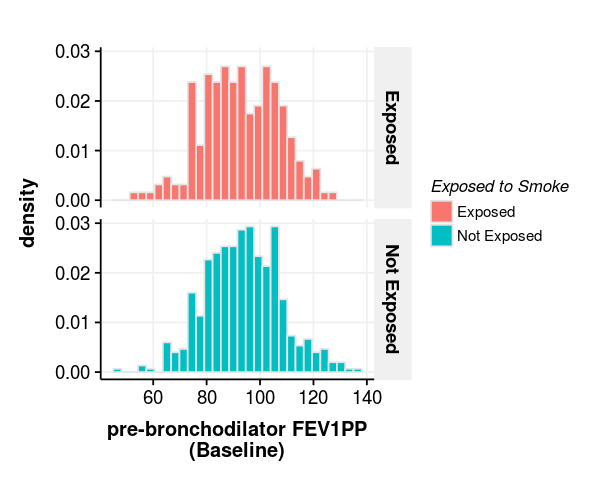

In [217]:
options(repr.plot.width = 5, repr.plot.height=4)

gp <- dat_camp_base %>%
    ggplot(aes(
        x = PREFEVPP, 
        y = ..density.., 
        fill = Expose_Smk)) +
    geom_histogram(color = "grey90") +     
    xlab("pre-bronchodilator FEV1PP\n(Baseline)") +
    labs(fill = "Exposed to Smoke") + 
    facet_grid(Expose_Smk~.) +
    theme_Publication() +  
    theme(
        legend.direction = "vertical",
        legend.box = "horizontal",
        legend.position = "right",
        legend.key.size = unit(1.0, 'lines'),
        legend.title = element_text(size = 10), 
        legend.text  = element_text(size = 9)) +
    theme(axis.title = element_text(size = 12))
           
print(gp)

In [230]:
tmp <- split(dat_camp_base$PREFEVPP, dat_camp_base$Expose_Smk)
t.test(tmp$Exposed, tmp$`Not Exposed`, alternative = "less")


	Welch Two Sample t-test

data:  tmp$Exposed and tmp$`Not Exposed`
t = -0.87828, df = 373.97, p-value = 0.1902
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf 0.9169963
sample estimates:
mean of x mean of y 
 92.70443  93.74948 


**as measured by change in FEV1PP after bronchodilator in children with asthma.**

In [ ]:
dat_camp_base$CHGFEVPP

In [ ]:
options(repr.plot.width=4, repr.plot.height=3)

gp <- dat_camp_base %>%
    ggplot(aes(x = Expose_Smk, y = CHGFEVPP, color = Expose_Smk)) +
    geom_violin() +     
    geom_jitter(width = 0.2, size = 1, alpha = 0.5) + 
    xlab("Exposed to Smoke") + 
    ylab("pre-bronchodilator FEV1PP\n(Baseline)") + 
    theme_Publication() + 
    theme(legend.position="none") + 
    theme(axis.title = element_text(size = 12))

print(gp)

### Hypothesis Two: Analyze if the exposure to smoking is associated with change in lung function from baseline to the last observation for each child

**as measured by the difference in pre-bronchodilator FEV1PP**

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”

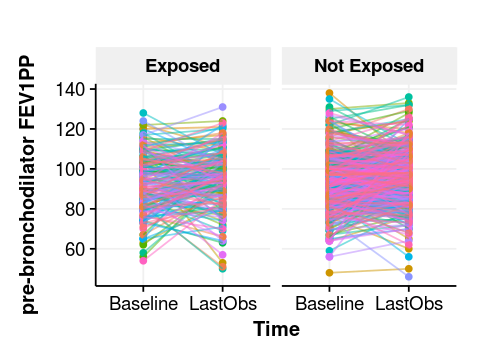

In [132]:
options(repr.plot.width=4, repr.plot.height=3)

gp <- dat_camp_final %>%
    ggplot(aes(
        x = Time, y = PREFEVPP, 
        group = as.character(id),
        color = as.character(id))) +
    geom_point() +
    geom_line(alpha = 0.5) +
    ylab("pre-bronchodilator FEV1PP") +
    theme_Publication() + 
    theme(legend.position="none") + 
    theme(axis.title = element_text(size = 12)) + 
    facet_grid(~Expose_Smk)
print(gp)

In [108]:
tmp <- dat_camp_final
tmp <- tmp %>% select(id, Time, PREFEVPP, Expose_Smk)
tmp <- tmp %>% spread(Time, PREFEVPP)
tmp <- tmp %>% 
    mutate(DELTA_BASELINE = LastObs - Baseline) %>%
    mutate(IS_PREFEVPP_INCREASE = LastObs > Baseline)
dat_PREFEVPP <- tmp

In [228]:
tmp <- table(dat_PREFEVPP$IS_PREFEVPP_INCREASE, dat_PREFEVPP$Expose_Smk)
tmp

       
        Exposed Not Exposed
  FALSE      85         208
  TRUE      118         275

In [229]:
res <- chisq.test(tmp)
res


	Pearson's Chi-squared test with Yates' continuity correction

data:  tmp
X-squared = 0.041455, df = 1, p-value = 0.8387


In [121]:
res$observed

       
        Exposed Not Exposed
  FALSE      85         208
  TRUE      118         275

In [122]:
res$expected

,Exposed,Not Exposed
FALSE,86.70408,206.2959
TRUE,116.29592,276.7041


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”

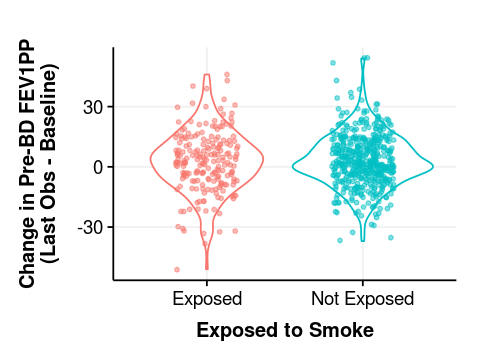

In [145]:
options(repr.plot.width=4, repr.plot.height=3)

gp <- dat_PREFEVPP %>%
    ggplot(aes(
        x = Expose_Smk, 
        y = DELTA_BASELINE, 
        color = Expose_Smk)) +
    geom_violin() +     
    geom_jitter(width = 0.2, size = 1, alpha = 0.5) + 
    xlab("Exposed to Smoke") + 
    ylab("Change in Pre-BD FEV1PP\n(Last Obs - Baseline)") +
    theme_Publication() + 
    theme(legend.position="none") + 
    theme(axis.title = element_text(size = 12))
           
print(gp)

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


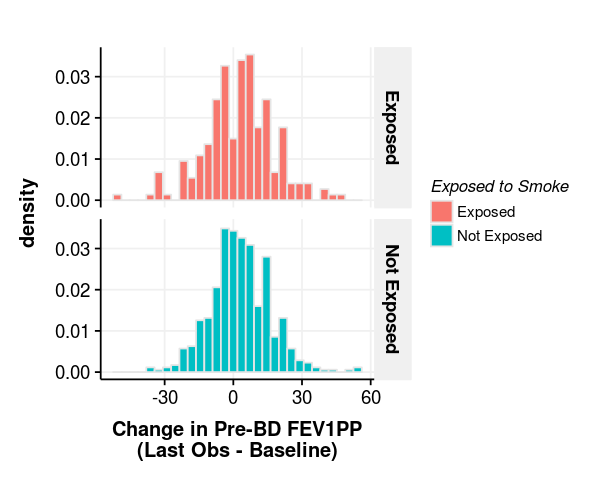

In [216]:
options(repr.plot.width = 5, repr.plot.height=4)

gp <- dat_PREFEVPP %>%
    ggplot(aes(
        x = DELTA_BASELINE, 
        y = ..density.., 
        fill = Expose_Smk)) +
    geom_histogram(color = "grey90") +     
    xlab("Change in Pre-BD FEV1PP\n(Last Obs - Baseline)") +
    labs(fill = "Exposed to Smoke") + 
    facet_grid(Expose_Smk~.) +
    theme_Publication() +  
    theme(
        legend.direction = "vertical",
        legend.box = "horizontal",
        legend.position = "right",
        legend.key.size = unit(1.0, 'lines'),
        legend.title = element_text(size = 10), 
        legend.text  = element_text(size = 9)) +
    theme(axis.title = element_text(size = 12))
           
print(gp)

In [123]:
head(dat_PREFEVPP)

id,Expose_Smk,Baseline,LastObs,DELTA_BASELINE,IS_PREFEVPP_INCREASE
1,Exposed,81,96,15,TRUE
2,Exposed,90,88,-2,FALSE
4,Not Exposed,104,106,2,TRUE
5,Not Exposed,112,98,-14,FALSE
9,Not Exposed,109,91,-18,FALSE
10,Not Exposed,98,98,0,FALSE


In [201]:
tmp <- split(dat_PREFEVPP$DELTA_BASELINE, dat_PREFEVPP$Expose_Smk)
t.test(tmp$Exposed, tmp$`Not Exposed`, alternative = "less")


	Welch Two Sample t-test

data:  tmp$Exposed and tmp$`Not Exposed`
t = -0.53259, df = 332.56, p-value = 0.2973
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 1.362705
sample estimates:
mean of x mean of y 
 2.586207  3.236025 
